# Importación de librerías y datos

In [4]:
#importar las librerías
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb

import warnings
warnings.filterwarnings("ignore")

In [5]:
import os 
os.getcwd()

'c:\\Users\\dgilr\\Desktop\\Pasantia'

In [84]:
#importar bases de datos

inflacion=pd.read_csv('inflacion.csv',delimiter=";")
desarrollopagosAT=pd.read_csv('desarrollopagosAT.csv')
desarrollopagosEL=pd.read_csv('desarrollopagosEL.csv')
siniestros = pd.read_csv('siniestros.csv')


In [85]:
#preparación

siniestros_at = siniestros[siniestros['Riesgo'] == 'AT'].groupby("Periodo")['Valor_Pagado'].mean()
siniestros_el = siniestros[siniestros['Riesgo'] == 'EL'].groupby("Periodo")['Valor_Pagado'].mean()


inflacionfiltrado = inflacion.loc[25:32,"Inflacion"]
inflacionfiltrado.index = siniestros_at.index

# Siniestros Accidentes de trabajos

## Cálculo alfas 2016-2022

In [86]:
alfa_at = pd.DataFrame({
    'Costo': siniestros_at.values.flatten(),  # Asegurarse de que sea un arreglo 1D
    'Inflacion': inflacionfiltrado.values.flatten()  # Asegurarse de que sea un arreglo 1D
}, index=inflacionfiltrado.index)

alfa_at
alfa_at["alfa"]=0

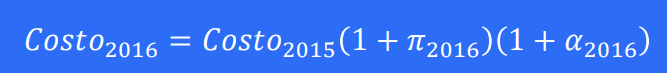

In [87]:
#Cálculo de alfa
costo = alfa_at.Costo.values
inflacion_at = alfa_at.Inflacion.values
alfatemp = []

for i in range(len(costo)-1):
    alfatemp.append(costo[i+1]/(costo[i]*(1+inflacion_at[i+1])) - 1)
alfa_at["alfa"][1:8] = alfatemp
alfa_at["alfa"][0:1] = np.NaN

alfa_at

,Costo,Inflacion,alfa
Periodo,,,
2015,14.995094,0.053056,NaN
2016,16.190490,0.053963,0.024438
2017,17.617992,0.055277,0.031170
2018,19.969143,0.063357,0.065919
2019,22.957189,0.062752,0.081751
2020,24.784282,0.063962,0.014686
2021,27.151399,0.070130,0.023716
2022,29.140790,0.066726,0.006135


In [88]:
alfa_el = pd.DataFrame({
    'Costo': siniestros_el.values.flatten(),  # Asegurarse de que sea un arreglo 1D
    'Inflacion': inflacionfiltrado.values.flatten()  # Asegurarse de que sea un arreglo 1D
}, index=inflacionfiltrado.index)

alfa_el
alfa_el["alfa"]=0

<Axes: xlabel='Periodo'>

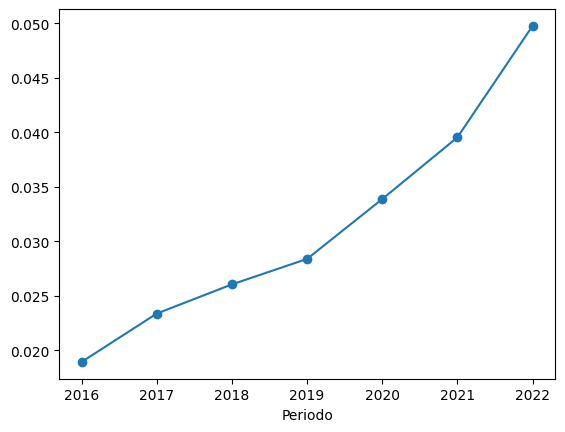

In [89]:
#Cálculo de alfa
costo = alfa_el.Costo.values
inflacion_el = alfa_el.Inflacion.values
alfatemp = []

for i in range(len(costo)-1):
    alfatemp.append(costo[i+1]/(costo[i]*(1+inflacion_el[i+1])) - 1)
alfa_el["alfa"][1:8] = alfatemp
alfa_el["alfa"][0:1] = np.NaN

alfa_el["alfa"].plot(kind="line", marker="o") 

In [129]:
from sklearn.linear_model import LinearRegression

In [148]:
X = alfa_el.index.values.reshape(-1, 1)
y = alfa_el.alfa.values

model = LinearRegression()
model.fit(X[1:], y[1:])

prediccion_alfa = []
años = [2023, 2024, 2025, 2026, 2027, 2028, 2029, 2030]
for i in años:
    prediccion_alfa.append(model.predict([[i]]) + np.random.normal(0, 0.0017))

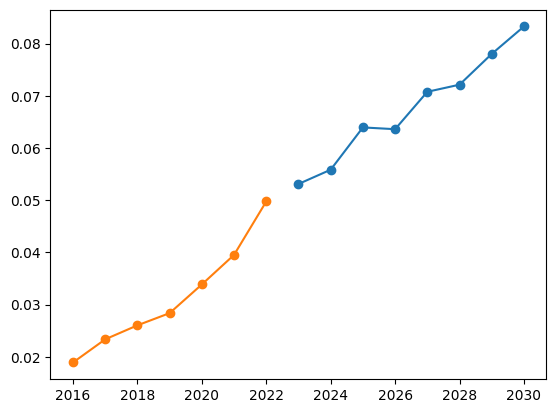

In [149]:
plt.plot(años, prediccion_alfa, marker="o")
plt.plot(X, y, marker="o")

In [150]:
model = LinearRegression()

In [151]:
X = inflacion.Periodo.values.reshape(-1, 1)
y = inflacion.Inflacion.values

model.fit(X, y)

prediccion_inflacion = []
for i in años:
    prediccion_inflacion.append(model.predict([[i]]) + np.random.normal(0, 0.0017))

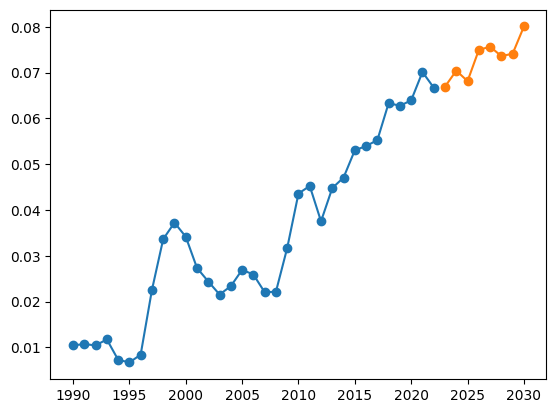

In [152]:
plt.plot(X, y, marker="o")
plt.plot(años, prediccion_inflacion, marker="o")

In [153]:
prediccion_alfa = np.array(prediccion_alfa).flatten()
prediccion_inflacion = np.array(prediccion_inflacion).flatten()

In [154]:
valor = [alfa_el.iloc[-1,0]]

for i in range(len(prediccion_alfa)):
    valor.append(valor[i]*(1+prediccion_alfa[i])*(1+prediccion_inflacion[i]))

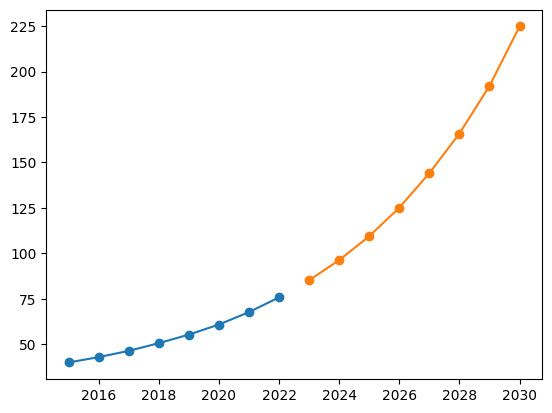

In [155]:
plt.plot(alfa_el.Costo, marker="o")
plt.plot(años, valor[1:], marker="o")

## Entendimiento desarrollo de pagos

### Accidente de trabajo

In [156]:
desarrollopagosAT.head()

,Ocurrencia,Pago,Valor_pagado
0,2018,2018,34.956130
1,2018,2019,32.076114
2,2018,2018,2.961294
3,2018,2018,41.921648
4,2018,2018,37.585113


In [169]:
años = desarrollopagosAT.Ocurrencia.unique()

A = len(desarrollopagosAT.query('Ocurrencia == @años[0] & Pago ==  @años[0]')) * 100 / len(desarrollopagosAT.query('Ocurrencia == @años[0]'))
B = len(desarrollopagosAT.query('Ocurrencia == @años[0] & Pago ==  @años[1]')) * 100 / len(desarrollopagosAT.query('Ocurrencia == @años[0]'))
C = len(desarrollopagosAT.query('Ocurrencia == @años[0] & Pago ==  @años[2]')) * 100 / len(desarrollopagosAT.query('Ocurrencia == @años[0]'))
D = len(desarrollopagosAT.query('Ocurrencia == @años[0] & Pago ==  @años[3]')) * 100 / len(desarrollopagosAT.query('Ocurrencia == @años[0]'))

A + B + C + D 

100.0

In [170]:
porcentaje_pagos_at = pd.DataFrame({
    'Ocurrencia': ["A", "B", "C", "D"],
    'Pago1': [A, B, C, D]
})

porcentaje_pagos_at.set_index("Ocurrencia", inplace=True)
porcentaje_pagos_at.head()

,Pago1
Ocurrencia,
A,59.977460
B,29.973133
C,7.036698
D,3.012709


In [235]:
def valor_triangular(df, años):
    gamma = []
    sigma = []
    for i in range(len(años)): 
        gamma.append(len(df.query('Ocurrencia == @años[@i] & Pago == @años[@i]')))
        try:
            sigma.append(len(df.query('Ocurrencia == @años[@i] & Pago == @años[@i+1]'))+ gamma[i])
        except:
            sigma.append(np.nan)
    
    return gamma, sigma

In [236]:
gamma, sigma = valor_triangular(desarrollopagosAT, años)

ChainLadderAT = pd.DataFrame({
    'Ocurrencia': años,
    '0': gamma,
    '1': sigma
})

In [237]:
ChainLadderAT.head()

,Ocurrencia,0,1
0,2018,59605,89392.0
1,2019,57305,90260.0
2,2020,55303,90342.0
3,2021,60407,90590.0
4,2022,64964,NaN


### Enfermedades laborales

In [ ]:
desarrollopagosEL.head()

,Ocurrencia,Pago,Valor_pagado
0,2018,2019,168.104438
1,2018,2019,49.782515
2,2018,2018,28.468882
3,2018,2020,66.836737
4,2018,2020,12.570004


In [171]:
años = desarrollopagosEL.Ocurrencia.unique()

A = len(desarrollopagosEL.query('Ocurrencia == @años[0] & Pago ==  @años[0]')) * 100 / len(desarrollopagosEL.query('Ocurrencia == @años[0]'))
B = len(desarrollopagosEL.query('Ocurrencia == @años[0] & Pago ==  @años[1]')) * 100 / len(desarrollopagosEL.query('Ocurrencia == @años[0]'))
C = len(desarrollopagosEL.query('Ocurrencia == @años[0] & Pago ==  @años[2]')) * 100 / len(desarrollopagosEL.query('Ocurrencia == @años[0]'))
D = len(desarrollopagosEL.query('Ocurrencia == @años[0] & Pago ==  @años[3]')) * 100 / len(desarrollopagosEL.query('Ocurrencia == @años[0]'))

A + B + C + D 

100.0

In [172]:
porcentaje_pagos_el = pd.DataFrame({
    'Ocurrencia': ["A", "B", "C", "D"],
    'Pago1': [A, B, C, D]
})

porcentaje_pagos_el.set_index("Ocurrencia", inplace=True)
porcentaje_pagos_el.head()

,Pago1
Ocurrencia,
A,39.918115
B,29.930098
C,20.126822
D,10.024965


In [238]:
gamma, sigma = valor_triangular(desarrollopagosEL, años)

ChainLadderEL = pd.DataFrame({
    'Ocurrencia': años,
    '0': gamma,
    '1': sigma
})

In [239]:
ChainLadderEL.head()

,Ocurrencia,0,1
0,2018,39974,69946.0
1,2019,49851,74870.0
2,2020,39908,73002.0
3,2021,49407,74334.0
4,2022,35144,NaN


In [243]:
ChainLadderEL['1'].mean()

73038.0